In [1]:
from __init__ import *

# Plotting Functions


In [ ]:
def plot_tpr_per_attack(args, results_df):
    """
    Plot the TPR for each attack and watermarking method, with different models as lines.
    The plot will have one row per attack, and one column per watermarking method.
    with the X-axis showing the attack strength and the Y-axis showing the TPR@FPR=0.01.
    """
    results_df['set_fpr'].unique()[0] # set_fpr should be the same for all experiments, so we can just take the first value

    # drop the no_attack case from the results_df
    results_df = results_df[results_df['attack_name'] != 'no_attack']


    attack_names = results_df['attack_name'].unique()
    wm_methods = results_df['wm_method'].unique()
    models = results_df['model_id'].unique()

    # order the attacks and methods based on the order in name_mapping
    attack_names = np.array(sorted(attack_names, key=lambda x: list(ATTACK_NAME_MAPPING.keys()).index(x)))
    wm_methods = np.array(sorted(wm_methods, key=lambda x: list(METHODS_NAME_MAPPING.keys()).index(x)))
    models = np.array(sorted(models, key=lambda x: list(MODEL_NAME_MAPPING.keys()).index(x)))

    # for each attack (rows), plot all 4 WM methods in 4 sublpots (cols), all 2 models as lines

    ncols = wm_methods.shape[0]# per method, ülus one for title
    nrows = attack_names.shape[0] # for each attack
    fs = 13
    fs_xticks = 10
    fs_yticks = 10
    fs_title = 14
    y_adj = 1.15
    title_height_ratio = 0.45#0.65 # .55 for small plts
    height_correction = 0
    sp_width = 2
    sp_height = 1.25 # .25 for full-all-attack-plot


    fig, gs, title_axes = setup_gridspec_figure(
        nrows=nrows, ncols=ncols ,
        fs=fs, fs_title=fs_title,
        y_adj=y_adj, title_height_ratio=title_height_ratio,
        sp_width=sp_width, sp_height=sp_height, height_correction=height_correction,
        wspace=0.12, hspace=0.1,
    )

    # set the titles for each row, as the attack names
    for i, ax in enumerate(title_axes):
        name = f"{ATTACK_NAME_MAPPING[attack_names[i]]['name']} ({ATTACK_NAME_MAPPING[attack_names[i]]['x_axis']})"
        ax.text(0.5, -0.42, name, fontsize=fs, ha="center", va="center")
                      
    handles, labels = [], []

    # loop through all attacks (rows), and then per attack, loop through all WM methods
    for i, attack_name in enumerate(attack_names): # rows
        attack_df = results_df[results_df['attack_name'] == attack_name]
        if attack_name not in ATTACK_NAME_MAPPING:
            continue

        axes = [fig.add_subplot(gs[2*i +1, j]) for j in range(ncols)]
        for j, wm_method in enumerate((wm_methods)): # columns
            # if wm_method == "title": # last column is title of the attack
            #     axes[j].axis('off')
            #     axes[j].text(-0.0, 0.5, ATTACK_NAME_MAPPING[attack_name]['name'], fontsize=fs, ha="left", va="center", rotation=90)
            #     # if i == 0:
            #     #     axes[j].set_title('Attacktype', fontsize=fs)
            # else:
            wm_df = attack_df[attack_df['wm_method'] == wm_method]
            
            # Set axis direction based on attack type
            if ATTACK_NAME_MAPPING[attack_name]['order'] == 'low-to-high':
                axes[j].invert_xaxis()
                
            if i == 0:
                axes[j].set_title(METHODS_NAME_MAPPING[wm_method], fontsize=fs)
            
            axes[j].set_yticks(np.arange(0, 1.1, 0.5))
            axes[j].set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=fs_yticks)
            axes[j].set_ylim([-0.1, 1.1])
            axes[j].grid(True, linestyle='--', alpha=0.5, axis='y')
            # set top and right spines to invisible
            axes[j].spines['top'].set_visible(False)
            axes[j].spines['right'].set_visible(False)

            if j == 0:# Add y-axis label to the first plot in each row
                axes[j].set_ylabel("TPR@1%FPR", fontsize=fs)
            else:# disable y-axis labels for all but the first column
                plt.setp(axes[j].get_yticklabels(), visible=False)
                #plt.setp(axes[j].get_yticklines(), visible=False)

            for model in models: # lines
                model_df = wm_df[wm_df['model_id'] == model]
                # Check if the model_df is empty
                if model_df.empty:
                    print(f"Warning: No data for {attack_name}, {wm_method}, {model}\n")
                    continue

                if attack_name == 'no_attack':
                    # No need to order the attack strengths for the no attack case
                    strengths = model_df['attack_strength'].unique()
                    results = model_df['tpr_empirical'].values
                    ci_lower = model_df['tpr_ci_lower_percentile'].values
                    ci_upper = model_df['tpr_ci_upper_percentile'].values
                else:
                    strengths, results, ci_lower, ci_upper = order_attack_strengths(
                        ATTACK_NAME_MAPPING[attack_name]['order'],
                        model_df['attack_strength'], 
                        model_df['tpr_empirical'],
                        model_df['tpr_ci_lower_percentile'],
                        model_df['tpr_ci_upper_percentile'],
                        ATTACK_NAME_MAPPING[attack_name]['cast_to_int'],
                        attack_name=attack_name,
                    )
                
                label = MODEL_NAME_MAPPING[model]['name']
                
                # Plot using actual strength values
                line, = axes[j].plot(strengths, results,
                            marker=MODEL_NAME_MAPPING[model]['marker'],
                            linestyle=MODEL_NAME_MAPPING[model]['line'],
                            label=label,
                            color=MODEL_NAME_MAPPING[model]['color'],
                            markersize=MODEL_NAME_MAPPING[model]['size'],
                            linewidth=MODEL_NAME_MAPPING[model]['linewidth'],

                            )
                
                if (not np.isnan(ci_lower).any() and not np.isnan(ci_upper).any()) or (len(ci_lower) > 0 and len(ci_upper) > 0):
                    axes[j].fill_between(strengths, ci_lower, ci_upper, color=MODEL_NAME_MAPPING[model]['color'], alpha=0.2)
                    if attack_name == 'no_attack':
                        axes[j].plot(strengths, ci_lower, color=MODEL_NAME_MAPPING[model]['color'], alpha=0.2, marker='x', linestyle='--')
                        axes[j].plot(strengths, ci_upper, color=MODEL_NAME_MAPPING[model]['color'], alpha=0.2, marker='x', linestyle='--')

                            
                if label not in labels:
                    handles.append(line)
                    labels.append(label)

                # Set only the actual strength values as ticks
                axes[j].set_xticks(strengths)
                axes[j].set_xticklabels(strengths, fontsize=fs_xticks)
                #axes[j].set_xlim([strengths[0]-0.1, strengths[-1]+0.1])
            
            

    
    fig.legend(loc='lower center', bbox_to_anchor=(0.26, -0.15, 0.5, 0.5), ncol=len(models), handles=handles, labels=labels, fontsize=fs, frameon=False)
    # -0.15 for 2 rows
    # -0.07 for 3 rows
    plt.savefig(args.output_plot, bbox_inches='tight', dpi=300, pad_inches=0, transparent=True)
    plt.show()
    plt.close()
    print(f"Plot saved to {args.output_plot}")



In [ ]:
def plot_tpr_per_metric(args, results_df, metric_name, metric_column, title_suffix, xlabel, xlim):
    """
    Generic plotting function that can use any metric for the x-axis
    
    Parameters:
    - args: The command line arguments
    - metric_name: String identifier for the metric (used in filenames)
    - metric_column: Name of the column to use for x-axis values
    - title_suffix: Text to add to the plot title
    - xlabel: Label for the x-axis
    """
    # results_df = pd.read_csv(args.output_csv)
    
    attack_names = results_df['attack_name'].unique()
    wm_methods = results_df['wm_method'].unique()
    models = results_df['model_id'].unique()

    attack_names = np.array(sorted(attack_names, key=lambda x: list(ATTACK_NAME_MAPPING.keys()).index(x)))
    wm_methods = np.array(sorted(wm_methods, key=lambda x: list(METHODS_NAME_MAPPING.keys()).index(x)))
    models = np.array(sorted(models, key=lambda x: list(MODEL_NAME_MAPPING.keys()).index(x)))

    # Setup figure with same layout
    ncols = wm_methods.shape[0] + 1 # per method, plus one for title
    nrows = attack_names.shape[0]  # for each attack
    fs = 10
    fs_xticks = 8
    fs_yticks = 8
    fs_title = 14
    y_adj = 0.937
    title_height_ratio = 0.35
    title = (
        f'Watermarking performance vs {title_suffix}\n'
        f'for dataset "{args.prompt_dataset}" for experiments in \n'
        f'{args.dataset_identifier}'
    )

    fig, gs, title_axes = setup_gridspec_figure(
        nrows=nrows, ncols=ncols,
        fs=fs, title=title, fs_title=fs_title,
        y_adj=y_adj, title_height_ratio=title_height_ratio,
        sp_width=2, sp_height=1.75
    )

    # # Set row titles (attack names)
    # for i, ax in enumerate(title_axes):
    #     ax.text(0.5, 0.25, ATTACK_NAME_MAPPING[attack_names[i]]['name'], 
    #             fontsize=fs_title, fontweight="bold", ha="center", va="center")
                      
    handles, labels = [], []
    xticks_num = 3
    xticks_stepsize = (xlim[1] - xlim[0]) / xticks_num
    xticks = np.round(np.arange(xlim[0], xlim[1] + xticks_stepsize, xticks_stepsize), 2)
    xlim_buffer = np.abs(xlim[1] - xlim[0]) * 0.07
    xlim = (xlim[0] - xlim_buffer, xlim[1] + xlim_buffer)

    # Loop through attacks and watermarking methods
    for i, attack_name in enumerate(attack_names): # rows
        attack_df = results_df[results_df['attack_name'] == attack_name]
        if attack_name not in ATTACK_NAME_MAPPING:
            continue

        axes = [fig.add_subplot(gs[2*i +1, j]) for j in range(ncols)]
        for j, wm_method in enumerate(np.concatenate((wm_methods, ["title"]))): # columns
            if wm_method == "title": # last column is title of the attack
                axes[j].axis('off')
                axes[j].text(0.1, 0.5, ATTACK_NAME_MAPPING[attack_name]['name'], fontsize=fs, fontweight="bold", ha="left", va="center")
                if i == 0:
                    axes[j].set_title('Attacktype', fontsize=fs)
            else:
                wm_df = attack_df[attack_df['wm_method'] == wm_method]

                # Set axis direction based on attack type
                if ATTACK_NAME_MAPPING[attack_name]['order'] == 'low-to-high':
                    axes[j].invert_xaxis()
                    
                if i == 0:
                    axes[j].set_title(METHODS_NAME_MAPPING[wm_method], fontsize=fs)
                
                axes[j].set_ylim([-0.1, 1.1])
                axes[j].set_yticks(np.arange(0, 1.1, 0.25))
                axes[j].set_yticklabels(np.arange(0, 1.1, 0.25), fontsize=fs_yticks)
                axes[j].set_xlim(xlim)
                axes[j].set_xticks(xticks)
                axes[j].set_xticklabels(xticks, fontsize=fs_xticks)
                axes[j].grid(True, linestyle='--', alpha=0.5)
                # set top and right spines to invisible
                axes[j].spines['top'].set_visible(False)
                axes[j].spines['right'].set_visible(False)

                if j == 0:# Add y-axis label to the first plot in each row
                    axes[j].set_ylabel("TPR@1%FPR")
                else:# disable y-axis labels for all but the first column
                    plt.setp(axes[j].get_yticklabels(), visible=False)
                    plt.setp(axes[j].get_yticklines(), visible=False)
                
                # For quality metrics (like CLIP similarity score), higher is better, 
                # so have higher values to the left
                if "score" in metric_column.lower() or "similarity" in metric_column.lower():
                    #print(f"enter score for {metric_column}")
                    if axes[j].get_xlim()[0] < axes[j].get_xlim()[1]:  # If lower values are on left
                        #print(f"enter score for {metric_column} invert")
                        axes[j].invert_xaxis()  # Invert so higher values are on left
                # For distance metrics (like FID), lower is better, so have lower values to the left
                if "fid" in metric_column.lower() or "distance" in metric_column.lower():
                    #print(f"enter fid for {metric_column}")
                    if axes[j].get_xlim()[0] > axes[j].get_xlim()[1]:  # If higher values are on left
                        #print(f"enter fid for {metric_column} invert")
                        axes[j].invert_xaxis()  # Invert so lower values are on left

                for model in models: # lines
                    model_df = wm_df[wm_df['model_id'] == model]
                    
                    # Check if the metric column exists
                    if metric_column not in model_df.columns:
                        print(f"Warning: {metric_column} not found for {attack_name}, {wm_method}, {model}")
                        continue

                    # Sort by the metric column
                    df_sorted = model_df.sort_values(by=metric_column)
                    x_values = df_sorted[metric_column].values
                    tpr_values = df_sorted['tpr_empirical'].values
                    attack_strengths = df_sorted['attack_strength'].values

                    label = MODEL_NAME_MAPPING[model]['name']
                    
                    line, = axes[j].plot(x_values, tpr_values,
                                marker=MODEL_NAME_MAPPING[model]['marker'],
                                linestyle=MODEL_NAME_MAPPING[model]['line'],
                                label=label,
                                color=MODEL_NAME_MAPPING[model]['color'])
                    
                    # Add attack strength as text near each point for reference
                    for k, (x, y, strength) in enumerate(zip(x_values, tpr_values, attack_strengths)):
                        if k % 2 == 0:  # Only label every other point to avoid clutter
                            axes[j].annotate(f"{strength}", (x, y), 
                                            textcoords="offset points", 
                                            xytext=(0, 5), 
                                            ha='center',
                                            fontsize=7)
                                
                    if label not in labels:
                        handles.append(line)
                        labels.append(label)

    
                
                

    fig.legend(loc='upper center', bbox_to_anchor=(0.2, 0.4, 0.5, 0.5), ncol=len(models), handles=handles, labels=labels)
    
    output_plot = args.output_plot.replace('.svg', f'_{metric_name}.svg')
    plt.savefig(output_plot, bbox_inches='tight', dpi=300)
    #plt.show()
    plt.close()
    print(f"\n{title_suffix} plot saved to {output_plot}")


In [2]:
args = Namespace()
args.exp_name = 'exp1'


# specify which experimental setup we want to plot
args.num_imgs = 2000
args.prompt_dataset = 'coco'  # 'mjprompts' or 'coco'

# for exp1, we merge results over wmch_16 for Flux and wmch_4 for SD
args.dataset_identifier = [f'num_{args.num_imgs}_fpr_0.01_cfg_3.0_wmch_16_infsteps_50', # flux
                           f'num_{args.num_imgs}_fpr_0.01_cfg_0_wmch_16_infsteps_4', # flux_s
                           f'num_{args.num_imgs}_fpr_0.01_cfg_3.0_wmch_4_infsteps_50']  # sd

# create the output directories and ffilenames
args.input_dir = os.path.join('experiments', args.exp_name)
args.output_dir = os.path.join('experiments', args.exp_name, '_results', args.prompt_dataset,  args.dataset_identifier[0])
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

    
args.output_plot = os.path.join(args.output_dir, f'exp1_{args.prompt_dataset}_plot.pdf')
args.merged_result_csv = os.path.join(args.output_dir, f'exp1_{args.prompt_dataset}_merged.csv')
# merged results already created in 5_merge_results.py
results_df = pd.read_csv(args.merged_result_csv)

# filter_attacks = np.array(['brightness_factor', 'gaussian_std'])
#filter_attacks = np.array(['crop', 'crop_scale', 'r_degree'])
#filter_attacks = np.array(['jpeg_ratio', 'gaussian_blur_r'])
# filter_attacks = np.array(['adv_surr_resnet18', 'adv_embed_klvae8'])
# #filter_attacks = np.array(['no_attack'])

# if filter_attacks.size > 0:
#    results_df = results_df[results_df['attack_name'].isin(filter_attacks)]
#    args.output_plot = os.path.join(args.output_dir, f'exp1_{args.prompt_dataset}_plot_{filter_attacks}.pdf')

# filter models
filter_models = np.array(['flux_s', 'flux'])
if filter_models.size > 0:
    results_df = results_df[results_df['model_id'].isin(filter_models)]
    args.output_plot = os.path.join(args.output_dir, f'exp1_{args.prompt_dataset}_plot_{filter_models}.pdf')

# 1. plot TPR vs attack strength
plot_tpr_per_attack(args, results_df)

# # 2. plot TPR vs CLIP 
# xmin = results_df['clip_score_wm'].min()
# xmax = results_df['clip_score_wm'].max()
# plot_tpr_per_metric(
#     args, 
#     results_df, 
#     metric_name="clip_score_wm", 
#     metric_column="clip_score_wm",
#     title_suffix="CLIP similarity score",
#     xlabel="CLIP score (↑)",
#     xlim=[xmin, xmax]
# )
# xmin = results_df['clip_score_nowm'].min()
# xmax = results_df['clip_score_nowm'].max()
# plot_tpr_per_metric(
#     args, 
#     results_df, 
#     metric_name="clip_score_nowm", 
#     metric_column="clip_score_nowm",
#     title_suffix="CLIP similarity score",
#     xlabel="CLIP score (↑)",
#     xlim=[xmin, xmax]
# )

# # 3. plot TPR vs diff 
# xmin = results_df['wm_diff'].min()
# xmax = results_df['wm_diff'].max()
# plot_tpr_per_metric(
#     args, 
#     results_df, 
#     metric_name="wm_diff", 
#     metric_column="wm_diff",
#     title_suffix="Abs. Mean Difference (originial - recovered)",
#     xlabel="Diff (↓)",
#     xlim=[xmin, xmax]
# )

# # 4. plot TPR vs FID (WM vs COCO)
# xmin = results_df['fid_wm_coco'].min()
# xmax = results_df['fid_wm_coco'].max()
# plot_tpr_per_metric(
#     args, 
#     results_df, 
#     metric_name="fid_wm_coco", 
#     metric_column="fid_wm_coco",
#     title_suffix="FID (WM vs COCO)",
#     xlabel="FID (↓)",
#     xlim=[xmin, xmax]
# )

# # 5. plot TPR vs FID (WM vs NOWM)
# xmin = results_df['fid_wm_nowm'].min()
# xmax = results_df['fid_wm_nowm'].max()
# plot_tpr_per_metric(
#     args, 
#     results_df, 
#     metric_name="fid_wm_nowm", 
#     metric_column="fid_wm_nowm",
#     title_suffix="FID (WM vs NOWM)",
#     xlabel="FID (↓)",
#     xlim=[xmin, xmax]
# )

NameError: name 'plot_tpr_per_attack' is not defined

# Numerical Table Results
### Calculate Mean over Attack Strengths

In [ ]:
results_df

In [ ]:
model_ids = results_df['model_id'].unique()
wm_methods = results_df['wm_method'].unique()
attack_types = results_df['attack_type'].unique()
attack_names = results_df['attack_name'].unique()
#wm_chs = results_df['wm_ch'].unique()
attack_strengths = results_df['attack_strength'].unique()

print(f"model_ids: {model_ids}")
print(f"wm_methods: {wm_methods}")
print(f"attack_types: {attack_types}")
print(f"attack_names: {attack_names}")
#print(f"wm_chs: {wm_chs}")
print(f"attack_strengths: {attack_strengths}")

def print_metric_per_attack(results_df, model_ids, wm_methods, attack_names, metric="tpr_empirical"):
    errors = 0
    
    # loop over model_ids
    for model_id in model_ids:
        model_df = results_df[results_df['model_id'] == model_id]
        # check if empty
        if model_df.empty:
            
            print(f"Model ID {model_id} has no data.")
            continue
        else:
            print(f"\nModel: {model_id}")
        
        # loop over wm_methods
        for wm_method in wm_methods:
            wm_df = model_df[model_df['wm_method'] == wm_method]
            # check if empty
            if wm_df.empty:
                
                print(f"\tWM method {wm_method} has no data for model ID {model_id}.")
                continue
            else:
                print(f"\tWM method: {wm_method}")
            # loop over attack_types
            for attack_name in attack_names:
                attack_df = wm_df[model_df['attack_name'] == attack_name]
                # check if empty
                if attack_df.empty:
                    errors += 1	
                    print(f"\t\tMISSING Attack name {attack_name} has no data for model ID {model_id} and WM method {wm_method}.")
                    continue
                else:
                    print(f"\t\tAttack name: {attack_name}")
                #for wm_ch in wm_chs:
                    #wm_ch_df = attack_df[attack_df['wm_ch'] == wm_ch]
                    # check if empty
                    #if wm_ch_df.empty:
                        #print(f"\n\t\t\tWM channel {wm_ch} has no data for attack name {attack_name}, model ID {model_id}, and WM method {wm_method}.")
                        #continue
                    #else:
                        #print(f"\n\t\t\tWM channel: {wm_ch}")
                    
                
                
                # for no_attack, there should be exactly one rows in the df (one attack strength), and for all other attacks, there should be exactly 5 rows (1 per attack strengths)
                # There might be duplicates per case of model_id X wm_method X attack_name, so we need to check the number of unique attack strengths
                num_data_points = len(attack_df) # could be more or less than expected, either duolicates or missing rows
                num_attack_strengths = attack_df['attack_strength'].nunique() # could be less than expected, if some attack strengths are missing, upper bound 5

                if attack_name == 'no_attack':
                    if num_data_points != 1:
                        errors += 1
                        print(f"\t\t\tExpected exactly 1 data point for no_attack, but found {num_data_points}.")
                        continue
                else:
                    if num_attack_strengths != 5:
                        errors += 1
                        print(f"\t\t\tTOO FEW ATTACKS, {num_attack_strengths} unique attack strengths for {num_data_points} data points for {attack_name}.")
                        continue
                    if num_data_points != 5:
                        errors += 1
                        print(f"\t\t\tDUPLICATES, {num_data_points} data points over {num_attack_strengths} unique attack strengths for {attack_name}.")
                        continue
                    

                    
                #print(f"\t\t\t\tattack strengths: {attack_strengths}")
                #print(f"\t\t\t\ttpr empirical values: {attack_df['tpr_empirical'].values}")
                #print(attack_df)
                mean_metric = attack_df[metric].mean()
                std_metric = attack_df[metric].std()
                print(f"\t\t\t\t{metric}: {mean_metric:.3f}+-{std_metric:.3f}")
            
    if errors > 0:
        print(f"\n{errors} errors found in the results. Please check the output above.")


In [ ]:
#TPR
results_df = pd.read_csv(args.merged_result_csv)
args.output_plot = os.path.join(args.output_dir, f'exp1_{args.prompt_dataset}_plot.pdf')
#filter_attacks = np.array(['brightness_factor', 'gaussian_std'])
filter_attacks = np.array(['crop', 'crop_scale', 'r_degree'])
#filter_attacks = np.array(['jpeg_ratio', 'gaussian_blur_r'])
# filter_attacks = np.array(['adv_surr_resnet18', 'adv_embed_klvae8'])
#filter_attacks = np.array(['no_attack'])

if filter_attacks.size > 0:
   results_df = results_df[results_df['attack_name'].isin(filter_attacks)]
 
print_metric_per_attack(results_df, model_ids, wm_methods, attack_names, metric="tpr_empirical")

In [ ]:
#CLIP scores
# create new col called "clip_wm_nowm_diff" that is the difference between clip_score_wm and clip_score_nowm
results_df['clip_wm_nowm_diff'] = results_df['clip_score_wm'] - results_df['clip_score_nowm']

print_metric_per_attack(results_df, model_ids, wm_methods, attack_names, metric="clip_score_nowm")

In [ ]:
#FID
# create new col called "fid_diff" that is the difference between fid_wm_coco and fid_nowm_coco
results_df['fid_wm_coco_diff'] = results_df['fid_wm_coco'] - results_df['fid_nowm_coco']

print_metric_per_attack(results_df, model_ids, wm_methods, attack_names, metric="fid_nowm_coco")

In [ ]:
#Abs. Difference

print_metric_per_attack(results_df, model_ids, wm_methods, attack_names, metric="wm_diff")

In [ ]:
# results_df = pd.read_csv(args.merged_result_csv)

# x_var = 'wm_diff' 
# results_df_prc = results_df[results_df['wm_method'] == 'prc']  # nowm_diff should be same for all methods, as it IS NO method
# results_df_gs = results_df[results_df['wm_method'] == 'gs']

# counter = 0
# round_to = 3
# for model in results_df['model_id'].unique():
#     model_df_prc = results_df_prc[results_df_prc['model_id'] == model]
#     model_df_gs = results_df_gs[results_df_gs['model_id'] == model]
    
#     # Check if both dataframes are empty
#     if model_df_prc.empty or model_df_gs.empty:
#         print(f"Warning: No data for model {model} in one of the methods.")
#         continue
    
#     for attack in results_df['attack_name'].unique():
#         attack_df_prc = model_df_prc[model_df_prc['attack_name'] == attack]
#         attack_df_gs = model_df_gs[model_df_gs['attack_name'] == attack]
        
#         # Check if both dataframes are empty
#         if attack_df_prc.empty or attack_df_gs.empty:
#             print(f"Warning: No data for model {model} and attack {attack} in one of the methods.")
#             continue
        
#         for attack_val in attack_df_prc['attack_strength'].unique():
#             prc_val = attack_df_prc[attack_df_prc['attack_strength'] == attack_val][x_var].values
#             gs_val = attack_df_gs[attack_df_gs['attack_strength'] == attack_val][x_var].values
            
#             # Check if both values are present
#             if prc_val.size > 0 and gs_val.size > 0:
#                 prc_val = prc_val[0]
#                 gs_val = gs_val[0]

#             if np.round(prc_val, round_to) == np.round(gs_val, round_to):
#                 print(f"MATCH: Model {model}, Attack {attack}, Strength {attack_val}: PRC = {prc_val}, GS = {gs_val} (same)")
#             else:
#                 print(f"DIFF: Model {model}, Attack {attack}, Strength {attack_val}: PRC = {prc_val}, GS = {gs_val} (differs)")
#                 counter += 1
                

            

# if counter > 0:
#     print(f"\n{counter} differences found between PRC and GS for the same model, attack, and attack strength.")




# # calcualte correlation between tpr_empirical and wm_diff
# correlation = results_df[[x_var, 'tpr_empirical']].corr().iloc[0, 1]
# correlation = round(correlation, 3)
# print(f"\nCorrelation between TPR and WM Diff: {correlation}")


Correlation between tpr_empirical and unwatermarked: -0.637

Correlation between tpr_empirical and watermarked: -0.586


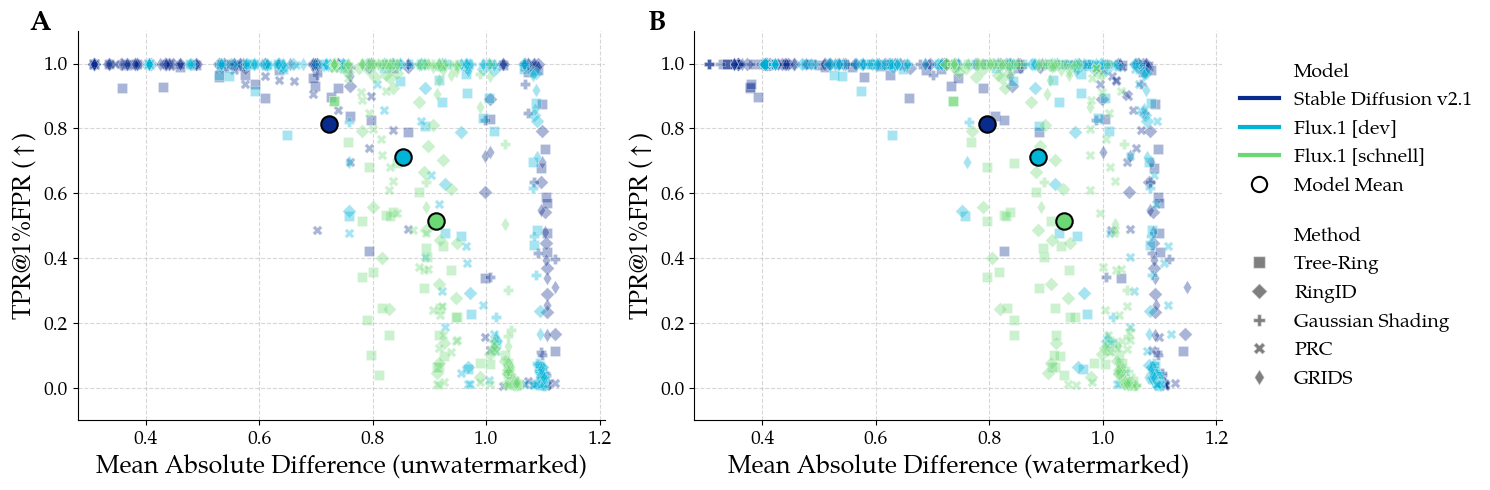

Correlation for Stable Diffusion v2.1: -0.597
Correlation for Flux.1 [dev]: -0.594
Correlation for Flux.1 [schnell]: -0.704


In [92]:
# and plot the correlation as a scatter plot
import seaborn as sns
import matplotlib.pyplot as plt

results_df = pd.read_csv(args.merged_result_csv)
args.output_plot = os.path.join(args.output_dir, f'exp1_{args.prompt_dataset}_plot.pdf')

x_vars = ['nowm_diff', 'wm_diff'] 
y_var = 'tpr_empirical'

DIFF_NAME_MAPPING = {
    'nowm_diff': 'unwatermarked',
    'wm_diff': 'watermarked',
}


fs = 18
fs_xticks = 14
fs_yticks = 14
x_ticks = np.round(np.arange(0, 1.21, 0.2), 2)
xlim = (0.28, 1.21)
y_ticks = np.round(np.arange(0, 1.1, 0.2), 2)

METHOD_MARKERS = { 
    'tr': 's',
    'rid': 'D',
    'gs': 'P',
    'prc': 'X',
    'grids': 'd',
}

 # the variable to plot on the x-axis, can be changed to any other metric


fig, axes = plt.subplots(1, len(x_vars), figsize=(15, 5))
title = ['A', 'B']

for i, x_var in enumerate(x_vars):
    
    # calcualte correlation between tpr_empirical and wm_diff
    correlation = results_df[[x_var, y_var]].corr().iloc[0, 1]
    correlation = round(correlation, 3)
    print(f"\nCorrelation between {y_var} and {DIFF_NAME_MAPPING[x_var]}: {correlation}")

    mean_diffs = results_df.groupby('model_id')[x_var].mean().reset_index()
    mean_tprs = results_df.groupby('model_id')[y_var].mean().reset_index()

    ax = axes[i]
    ax.text(-0.07, 1.02, title[i], fontsize=fs+2, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
    ax.set_xlabel(f'Mean Absolute Difference ({DIFF_NAME_MAPPING[x_var]})', fontsize=fs)
    ax.set_ylabel(r'TPR@1%FPR ($\uparrow$)', fontsize=fs)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, fontsize=fs_xticks)
    ax.set_ylim([-0.1, 1.1])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks, fontsize=fs_yticks)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(xlim)
    


    for model_id in np.array(sorted(results_df['model_id'].unique(), key=lambda x: list(MODEL_NAME_MAPPING.keys()).index(x))):
        model_df = results_df[results_df['model_id'] == model_id]
        mean_diff = mean_diffs[mean_diffs['model_id'] == model_id][x_var].values[0]
        mean_tpr = mean_tprs[mean_tprs['model_id'] == model_id][y_var].values[0]
        
        for wm_method in np.array(sorted(model_df['wm_method'].unique(), key=lambda x: list(METHODS_NAME_MAPPING.keys()).index(x))):
            wm_df = model_df[model_df['wm_method'] == wm_method]
            
            ax.scatter(wm_df[x_var], wm_df[y_var], 
                        color=MODEL_NAME_MAPPING[model_id]['color'],
                        marker=METHOD_MARKERS[wm_method],
                        s=50, alpha=0.35, edgecolors='white', linewidth=0.5,
                        zorder=2)  # Set zorder for regular points
        
        ax.scatter(mean_diff, mean_tpr, 
                    color=MODEL_NAME_MAPPING[model_id]['color'], 
                    marker='o',
                    s=140, edgecolors='black', linewidth=1.5, label=f'{MODEL_NAME_MAPPING[model_id]["name"]} (mean)',
                    zorder=3)  # Ensure mean points are on top
        

        
# manually add the legends labels for each model_id, three colors, and the markers (grey) for each wm_method
handles = [plt.Line2D([], [], linestyle='None', label=f'Model')]
for model_id in np.array(sorted(results_df['model_id'].unique(), key=lambda x: list(MODEL_NAME_MAPPING.keys()).index(x))):
    model_name = MODEL_NAME_MAPPING[model_id]['name']
    color = MODEL_NAME_MAPPING[model_id]['color']
    marker = METHOD_MARKERS['tr']  # use the 'tr' marker as a representative for the model
    handle = plt.Line2D([], [], color=color, marker='None', linestyle='-', linewidth=3, label=f'{model_name}',)
    handles.append(handle)
# add the handles for the wm_methods
handles.append(plt.Line2D([], [], color='none', marker='o', markersize=11, linestyle='None', markeredgecolor='black', markeredgewidth=1.5, label=f'Model Mean'))
wm_method_handles = [plt.Line2D([], [], linestyle='None', label=f'\nMethod')]
for wm_method in np.array(sorted(results_df['wm_method'].unique(), key=lambda x: list(METHODS_NAME_MAPPING.keys()).index(x))):
    wm_method_name = METHODS_NAME_MAPPING[wm_method]
    marker = METHOD_MARKERS[wm_method]
    handle = plt.Line2D([], [], color='black', marker=marker, linestyle='None', markersize=8, label=wm_method_name, alpha=0.5, markeredgecolor='white', linewidth=0.5)
    wm_method_handles.append(handle)
# combine the handles
handles = handles + wm_method_handles
plt.legend(handles=handles, bbox_to_anchor=(1., 0.5), loc='center left', fontsize=fs_xticks, frameon=False, ncol=1)
    
# remove top an right spines and add grid
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# tag = 'watermarked' if x_var == 'wm_diff' else 'unwatermarked'
# plt.xlabel(f'Mean Absolute Difference ({tag})' , fontsize=fs) 
# plt.ylabel(r'TPR@1%FPR', fontsize=fs)
# plt.xticks(x_ticks, fontsize=fs_xticks)
# plt.yticks(fontsize=fs_yticks)
# plt.xlim(xlim)
plt.tight_layout()

#plt.grid(True, linestyle='--', alpha=0.5)
#plt.title(f'Correlation between TPR and WM Diff (Correlation: {correlation})')
output_plot = args.output_plot.replace('.pdf', f'_tpr_vs_diffs.pdf')
plt.savefig(output_plot, bbox_inches='tight', dpi=300, pad_inches=0, transparent=True)
plt.show()
    
# print the corrs per model_id
for model_id in np.array(sorted(results_df['model_id'].unique(), key=lambda x: list(MODEL_NAME_MAPPING.keys()).index(x))):
    model_df = results_df[results_df['model_id'] == model_id]
    corr = model_df[[x_var, y_var]].corr().iloc[0, 1]
    corr = round(corr, 3)
    print(f"Correlation for {MODEL_NAME_MAPPING[model_id]['name']}: {corr}")


In [ ]:

# x_var = 'wm_diff'  # change this to any other metric you want to analyze
# #how many unique x_var values are there per model_id?
# for model_id in np.array(sorted(results_df['model_id'].unique(), key=lambda x: list(MODEL_NAME_MAPPING.keys()).index(x))):
#     model_df = results_df[results_df['model_id'] == model_id]
#     unique_x_var_values = model_df[x_var].nunique()
#     print(f"{MODEL_NAME_MAPPING[model_id]['name']} has {unique_x_var_values} unique {x_var} values.")

In [93]:
# we want to create a similar plot to above, only with (wm_metric vs wm_diff) 
# but, every wm_method has a different scale of its metric
# so we need to normalize the metric per wm_method
# and then plot the normalized metric vs wm_diff

# Normalize the metric per wm_method
def normalize_metric_per_wm_method(results_df, metrics):
    """
    Normalize the specified metric per wm_method.
    
    Parameters:
    - results_df: DataFrame containing the results
    - metric: list of metrics to jointly normalize (e.g., ['mean_wm_dist', 'mean_nowm_dist'])
    
    Returns:
    - DataFrame with normalized metric
    """
    normalized_df = results_df.copy()
    
    for wm_method in normalized_df['wm_method'].unique():
        wm_method_df = normalized_df[normalized_df['wm_method'] == wm_method]
        min_val = wm_method_df[metrics].min().min()
        max_val = wm_method_df[metrics].max().max()

       
            
        # if wm_method == "prc":
        #     # For PRC, we want to normalize the metric per model_id#
            
        for model in wm_method_df['model_id'].unique():
            model_df = wm_method_df[wm_method_df['model_id'] == model]
            min_val = model_df[metrics].min().min()
            max_val = model_df[metrics].max().max()
            
            # per metric, create new col with normalized values
            for metric in metrics:
                normalized_col_name = f'normalized_{metric}'
                print(f"Normalizing {metric} for wm_method {wm_method}, model {model}: min={min_val}, max={max_val}")
                normalized_df.loc[(normalized_df['wm_method'] == wm_method) & (normalized_df['model_id'] == model), normalized_col_name] = (
                    model_df[metric] - min_val) / (max_val - min_val)
        # else:
        #     # per metric, create new col with normalized values
        #     for metric in metrics:
        #         normalized_col_name = f'normalized_{metric}'
        #         print(f"Normalizing {metric} for wm_method {wm_method}: min={min_val}, max={max_val}")
        #         normalized_df.loc[normalized_df['wm_method'] == wm_method, normalized_col_name] = (
        #             wm_method_df[metric] - min_val) / (max_val - min_val)
            
             

    
    return normalized_df



In [94]:
results_df = pd.read_csv(args.merged_result_csv)
args.output_plot = os.path.join(args.output_dir, f'exp1_{args.prompt_dataset}_plot.pdf')

# Normalize the wm_diff metric
metrics = ['mean_wm_dist', 'mean_no_wm_dist']  # change this to any other metric you want to analyze

results_df = normalize_metric_per_wm_method(results_df, metrics)
results_df[['normalized_mean_wm_dist', 'normalized_mean_no_wm_dist']]

Normalizing mean_wm_dist for wm_method gs, model flux: min=0.49755615234375, max=0.9999912109375
Normalizing mean_no_wm_dist for wm_method gs, model flux: min=0.49755615234375, max=0.9999912109375
Normalizing mean_wm_dist for wm_method gs, model sd: min=0.497322265625, max=1.0
Normalizing mean_no_wm_dist for wm_method gs, model sd: min=0.497322265625, max=1.0
Normalizing mean_wm_dist for wm_method gs, model flux_s: min=0.4984892578125, max=0.9873125
Normalizing mean_no_wm_dist for wm_method gs, model flux_s: min=0.4984892578125, max=0.9873125
Normalizing mean_wm_dist for wm_method grids, model flux: min=0.003, max=1.0
Normalizing mean_no_wm_dist for wm_method grids, model flux: min=0.003, max=1.0
Normalizing mean_wm_dist for wm_method grids, model sd: min=0.005, max=1.0
Normalizing mean_no_wm_dist for wm_method grids, model sd: min=0.005, max=1.0
Normalizing mean_wm_dist for wm_method grids, model flux_s: min=0.0035, max=1.0
Normalizing mean_no_wm_dist for wm_method grids, model flux_s

,normalized_mean_wm_dist,normalized_mean_no_wm_dist
0,0.999767,0.003739
1,0.958309,0.004502
2,0.780743,0.004364
3,0.585292,0.005308
4,0.420220,0.003520
...,...,...
685,0.210420,0.059019
686,0.170271,0.055313
687,0.173254,0.065234
688,0.162145,0.074041


/tmp/ipykernel_2420303/683578629.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


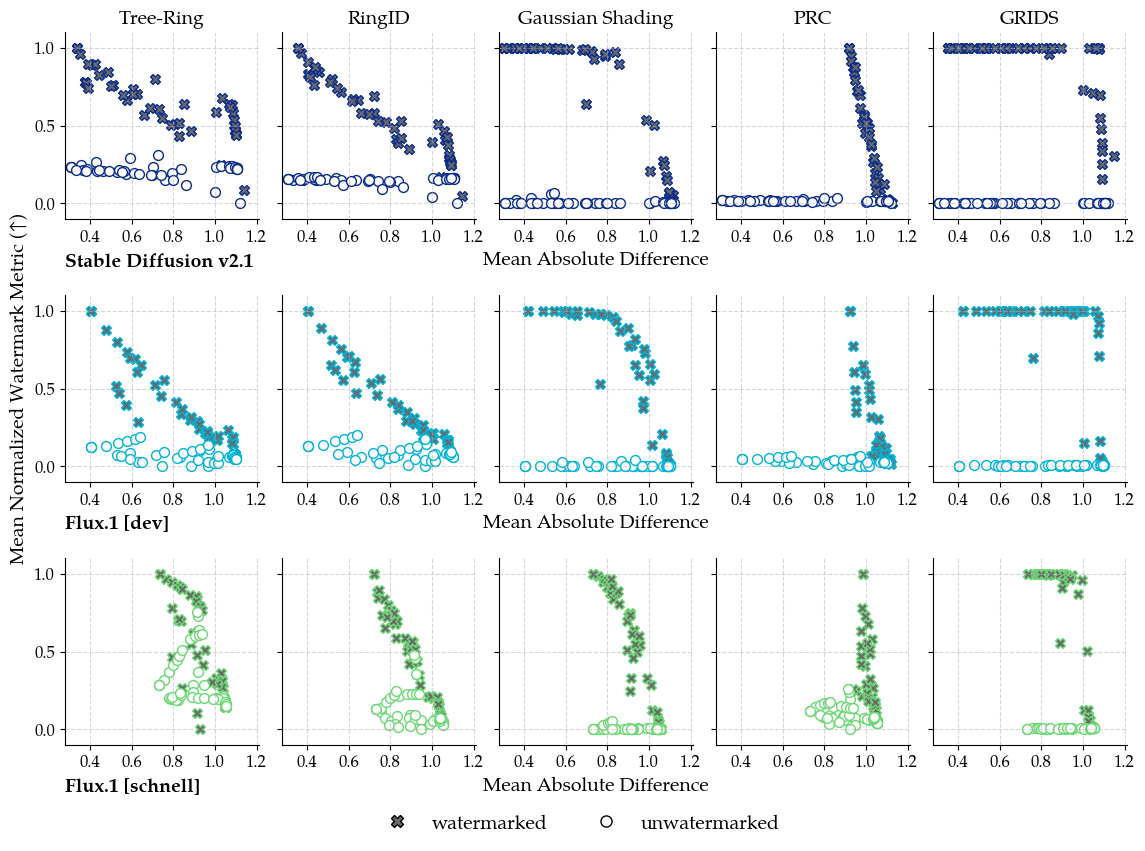

In [95]:
# filter_methods = np.array(['prc'])  # we only want to plot the rid method, as it is the most common one
# if filter_methods.size > 0:
#     results_df = results_df[results_df['wm_method'].isin(filter_methods)]
#     args.output_plot = args.output_plot.replace('.pdf', f'_{filter_methods}.pdf')

# filter_models = np.array(['sd'])  # we only want to plot the sd and flux models
# if filter_models.size > 0:
#     results_df = results_df[results_df['model_id'].isin(filter_models)]
#     args.output_plot = args.output_plot.replace('.pdf', f'_{filter_models}.pdf')

#x_var = 'wm_diff'  # the variable to plot on the x-axis, can be changed to any other metric
y_vars = ['normalized_mean_wm_dist', 'normalized_mean_no_wm_dist']  # the normalized metric to plot on the y-axis

METRIC_MARKERS = {
    'normalized_mean_wm_dist': {
        'marker': 'X',
        'color': 'blue',
        'linewidth': 1,
        'edgecolor' : 'dimgrey',
        'alpha': 1,
        'label' : 'watermarked',
        
    },
    'normalized_mean_no_wm_dist': {
        'marker': 'o',
        'color': 'turquoise',
        'linewidth': 1,
        'edgecolor' : 'white',
        'alpha': 1,
        'label' : 'unwatermarked',
        
    }
}

# Plot normalized watermark metrics vs. difference metrics


# Define styling constants
fs = 14  # Main font size
fs_xticks = 12
fs_yticks = 12
y_adj = 1.05
title_height_ratio = 0.1
sp_width = 2.5  # Width of each subplot
sp_height = 2.1  # Height of each subplot

# Get unique models and methods
wm_methods = np.array(sorted(results_df['wm_method'].unique(), 
                             key=lambda x: list(METHODS_NAME_MAPPING.keys()).index(x)))
model_ids = np.array(sorted(results_df['model_id'].unique(), 
                           key=lambda x: list(MODEL_NAME_MAPPING.keys()).index(x)))

# Use setup_gridspec_figure to create our layout
fig, gs, title_axes = setup_gridspec_figure(
    nrows=len(model_ids), ncols=5,  # One row per model, five columns (one per method)
    fs=fs, fs_title=fs+2,
    y_adj=y_adj, title_height_ratio=title_height_ratio,
    sp_width=sp_width, sp_height=sp_height,
    wspace=0.12, hspace=0.28,
    title=None  # No overall title
)


# Set model names as row titles
for i, model_id in enumerate(model_ids):
    title_axes[i].text(0.5, -0.22, 'Mean Absolute Difference', 
                     fontsize=fs,  ha='center', va='center')
    title_axes[i].text(0.0, -0.23, MODEL_NAME_MAPPING[model_id]['name'], 
                     fontsize=fs,  ha='left', va='center', fontweight='bold')

# Define common x and y limits for consistency
xticks = np.round(np.arange(0, 1.21, 0.2), 2)
xlim = (0.28, 1.21)
ylim = (-0.1, 1.1)  # Set y-axis limits for all subplots
yticks = np.round(np.arange(0, 1.21, 0.5), 2)  # Set y-axis ticks for all subplots

# Create plots
for i, model_id in enumerate(model_ids):
    for j, wm_method in enumerate(wm_methods):
        ax = fig.add_subplot(gs[2*i+1, j])

        # Filter data for this model and method
        filtered_df = results_df[(results_df['model_id'] == model_id) & 
                               (results_df['wm_method'] == wm_method)]

        for y_var in y_vars:
            if y_var == 'normalized_mean_wm_dist':
                x_var = 'wm_diff'
            elif y_var == 'normalized_mean_no_wm_dist':
                x_var = 'nowm_diff'
            else:
                raise ValueError(f"Unknown y_var: {y_var}")
                
            
                
            ax.scatter(filtered_df[x_var], filtered_df[y_var], 
                        #color=METRIC_MARKERS[y_var]['color'],
                        #marker=METHOD_MARKERS[wm_method],
                        color=METRIC_MARKERS[y_var]['edgecolor'],
                        marker=METRIC_MARKERS[y_var]['marker'],
                        linewidth=METRIC_MARKERS[y_var]['linewidth'],
                        s=50, alpha=METRIC_MARKERS[y_var]['alpha'],
                        edgecolors=MODEL_NAME_MAPPING[model_id]['color'],)
    
        # Set title and formatting
        if i == 0:
            ax.set_title(METHODS_NAME_MAPPING[wm_method], fontsize=fs)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xticks(xticks)
        ax.set_xlim(xlim)
        ax.set_xticklabels(xticks, fontsize=fs_xticks)
        ax.set_yticks(yticks)
        ax.set_ylim(ylim)
        ax.set_yticklabels(yticks, fontsize=fs_yticks)

        # Only show y-axis labels for the first subplot
        if j == 0 :
            if i == 1:
                ax.set_ylabel('Mean Normalized Watermark Metric (↑)', fontsize=fs)
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=fs_yticks)
        else:
            ax.set_yticklabels([])

# Add a shared x-axis label
#fig.text(0.3, -0.0, 'Mean Absolute Difference', ha='center', fontsize=fs)

# manually add the legends labels for each model_id, three colors, and the markers (grey) for each wm_method
handles = []
# for model_id in np.array(sorted(results_df['model_id'].unique(), key=lambda x: list(MODEL_NAME_MAPPING.keys()).index(x))):
#     model_name = MODEL_NAME_MAPPING[model_id]['name']
#     color = MODEL_NAME_MAPPING[model_id]['color']
#     marker = METHOD_MARKERS['tr']  # use the 'tr' marker as a representative for the model
#     handle = plt.Line2D([], [], color=color, marker='None', linestyle='-', linewidth=3, label=f'{model_name}',)
#     handles.append(handle)
# add the handles for the wm_methods
metric_handles = []
for metric in y_vars:
    marker = METRIC_MARKERS[metric]['marker']
    label = METRIC_MARKERS[metric]['label']
    linewidth = METRIC_MARKERS[metric]['linewidth'] 
    color = METRIC_MARKERS[metric]['edgecolor']
    handle = plt.Line2D([], [], color=color, marker=marker, markersize=8, label=label, alpha=1, linestyle='None',
                         linewidth=linewidth, markeredgecolor='black',)
    metric_handles.append(handle)
# combine the handles
handles = handles + metric_handles


# Add the combined legend
fig.legend(handles=handles, loc='center', 
          bbox_to_anchor=(0.5, 0.03), ncol=len(y_vars) + len(wm_methods),
          fontsize=fs, frameon=False)

plt.tight_layout()
output_plot = args.output_plot.replace('.pdf', f'_normalized_metrics_vs_diff.pdf')
plt.savefig(output_plot, bbox_inches='tight', dpi=300, pad_inches=0, transparent=True)
plt.show()


/tmp/ipykernel_2420303/1041609233.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


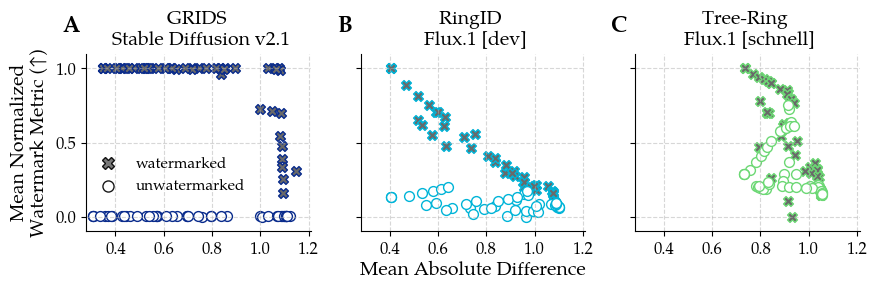

In [96]:
# Define the specific combinations we want to plot
selected_combinations = [
    {'model_id': 'sd', 'wm_method': 'grids'},
    {'model_id': 'flux', 'wm_method': 'rid'},
    {'model_id': 'flux_s', 'wm_method': 'tr'}
]

y_vars = ['normalized_mean_wm_dist', 'normalized_mean_no_wm_dist']  # the normalized metrics to plot on y-axis

METRIC_MARKERS = {
    'normalized_mean_wm_dist': {
        'marker': 'X',
        'color': 'blue',
        'linewidth': 1,
        'edgecolor': 'dimgrey',
        'alpha': 1,
        'label': 'watermarked',
    },
    'normalized_mean_no_wm_dist': {
        'marker': 'o',
        'color': 'turquoise',
        'linewidth': 1,
        'edgecolor': 'white',
        'alpha': 1,
        'label': 'unwatermarked',
    }
}

# Define styling constants
fs = 14  # Main font size
fs_xticks = 12
fs_yticks = 12
y_adj = 1.05
title_height_ratio = 0.1
sp_width = 2.9  # Width of each subplot
sp_height = 2.1  # Height of each subplot

# Use setup_gridspec_figure to create our layout with just 1 row and 3 columns
fig, gs, title_axes = setup_gridspec_figure(
    nrows=1, ncols=3,  # One row, three columns (one per selected combination)
    fs=fs, fs_title=fs+2,
    y_adj=y_adj, title_height_ratio=title_height_ratio,
    sp_width=sp_width, sp_height=sp_height,
    wspace=0.22, hspace=0.28,
    title=None  # No overall title
)

# Set titles
title_axes[0].text(0.5, -0.22, 'Mean Absolute Difference', 
                   fontsize=fs, ha='center', va='center')

# Define common x and y limits for consistency
xticks = np.round(np.arange(0, 1.21, 0.2), 2)
xlim = (0.28, 1.21)
ylim = (-0.1, 1.1)  # Set y-axis limits for all subplots
yticks = np.round(np.arange(0, 1.21, 0.5), 2)  # Set y-axis ticks for all subplots

title = ['A', 'B', 'C']  # Titles for each subplot
# Create plots for each selected combination
for j, combination in enumerate(selected_combinations):
    model_id = combination['model_id']
    wm_method = combination['wm_method']
    ax = fig.add_subplot(gs[1, j])
    
    # Filter data for this model and method
    filtered_df = results_df[(results_df['model_id'] == model_id) & 
                           (results_df['wm_method'] == wm_method)]
    
    # Plot each metric
    for y_var in y_vars:
        if y_var == 'normalized_mean_wm_dist':
            x_var = 'wm_diff'
        elif y_var == 'normalized_mean_no_wm_dist':
            x_var = 'nowm_diff'
        else:
            raise ValueError(f"Unknown y_var: {y_var}")
            
        ax.scatter(filtered_df[x_var], filtered_df[y_var], 
                   color=METRIC_MARKERS[y_var]['edgecolor'],
                   marker=METRIC_MARKERS[y_var]['marker'],
                   linewidth=METRIC_MARKERS[y_var]['linewidth'],
                   s=50, alpha=METRIC_MARKERS[y_var]['alpha'],
                   edgecolors=MODEL_NAME_MAPPING[model_id]['color'],)

    # Set title with model and method name
    model_name = MODEL_NAME_MAPPING[model_id]['name']
    method_name = METHODS_NAME_MAPPING[wm_method]
    ax.set_title(f"{method_name} \n {model_name}", fontsize=fs)
    ax.text(-0.07, 1.15, title[j], fontsize=fs+2, fontweight='bold', ha='center', va='center', transform=ax.transAxes)
    
    # Formatting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xticks(xticks)
    ax.set_xlim(xlim)
    ax.set_xticklabels(xticks, fontsize=fs_xticks)
    ax.set_yticks(yticks)
    ax.set_ylim(ylim)
    
    # Only show y-axis labels for the first subplot
    if j == 0:
        ax.set_ylabel('Mean Normalized\nWatermark Metric (↑)', fontsize=fs)
        ax.set_yticklabels(yticks, fontsize=fs_yticks)
    else:
        ax.set_yticklabels([])

# Add legend for metrics
handles = []
# for model_id in np.array(sorted(results_df['model_id'].unique(), key=lambda x: list(MODEL_NAME_MAPPING.keys()).index(x))):
#     model_name = MODEL_NAME_MAPPING[model_id]['name']
#     color = MODEL_NAME_MAPPING[model_id]['color']
#     marker = METHOD_MARKERS['tr']  # use the 'tr' marker as a representative for the model
#     handle = plt.Line2D([], [], color=color, marker='None', linestyle='-', linewidth=3, label=f'{model_name}',)
#     handles.append(handle)
# # add the handles for the wm_methods
metric_handles = []
for metric in y_vars:
    marker = METRIC_MARKERS[metric]['marker']
    label = METRIC_MARKERS[metric]['label']
    linewidth = METRIC_MARKERS[metric]['linewidth'] 
    color = METRIC_MARKERS[metric]['edgecolor']
    handle = plt.Line2D([], [], color=color, marker=marker, markersize=8, 
                       label=label, alpha=0.9, linestyle='None',
                       linewidth=linewidth, markeredgecolor='black',)
    metric_handles.append(handle)
# combine the handles
handles = handles + metric_handles

# Add the legend
fig.legend(handles=handles, loc='center', 

          bbox_to_anchor=(0.208, 0.3), ncol=1,
          fontsize=fs-3, frameon=False)

plt.tight_layout()
output_plot = args.output_plot.replace('.pdf', f'_normalized_metrics_vs_diff_selected_examples.pdf')
plt.savefig(output_plot, bbox_inches='tight', dpi=300, pad_inches=0, transparent=True)
plt.show()

In [ ]:
# calculate the correlation between the normalized no_wm_metric and wm_diff
for model_id in np.array(sorted(results_df['model_id'].unique(), key=lambda x: list(MODEL_NAME_MAPPING.keys()).index(x))):
    model_df = results_df[results_df['model_id'] == model_id]
    # corr = model_df[[x_var, 'normalized_mean_no_wm_dist']].corr().iloc[0, 1]
    # corr = round(corr, 3)
    # print(f"Correlation for {MODEL_NAME_MAPPING[model_id]['name']} between {x_var} and normalized_mean_no_wm_dist: {corr}")

    corr = model_df[[x_var, 'normalized_mean_wm_dist']].corr().iloc[0, 1]
    corr = round(corr, 3)
    print(f"Correlation for {MODEL_NAME_MAPPING[model_id]['name']} between {x_var} and normalized_mean_wm_dist: {corr}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 64x64 array with random values of either 1 or -1
np.random.seed(42)  # for reproducibility
dummy_image = np.random.choice([-1, 1], size=(64, 64))

# Create a figure with exact pixel size (1 inch = 72 pixels in matplotlib)
dpi = 72
figsize = (64/dpi, 64/dpi)  # figure size in inches

# Plot the image
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
im = ax.imshow(dummy_image, cmap='binary', interpolation='nearest')
ax.set_xticks([])  # Remove ticks
ax.set_yticks([])
ax.axis('off')  # Remove axes

# Save without padding and with exact size
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.savefig('dummy_image.png', dpi=dpi, bbox_inches='tight', pad_inches=0)
plt.close()

print(f"Image saved as dummy_image.png with shape {dummy_image.shape}")

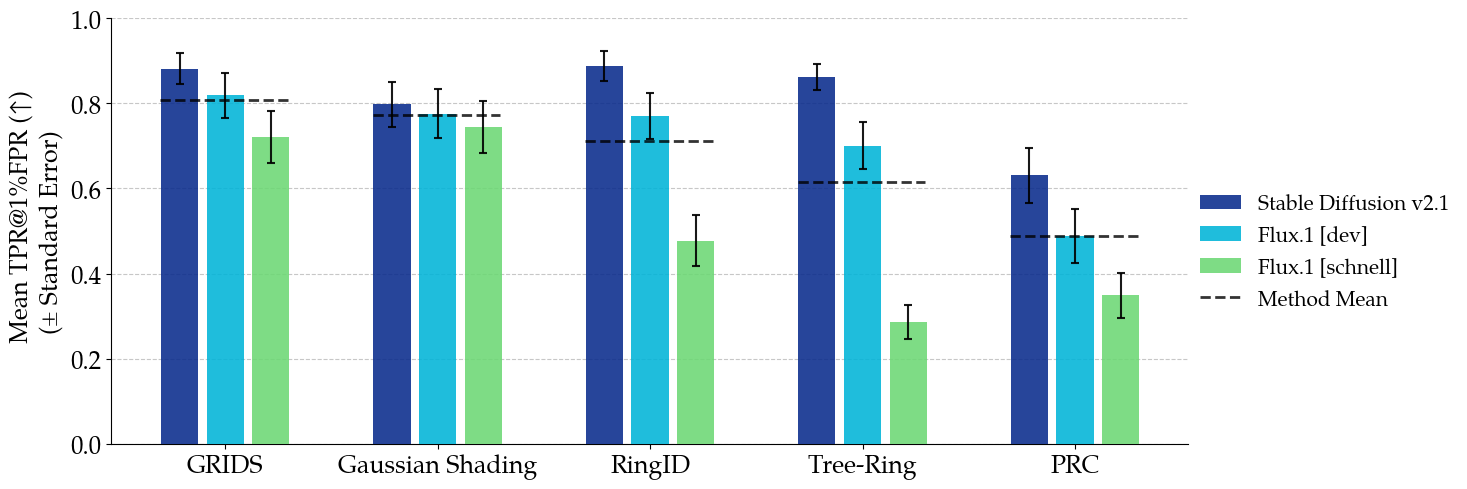

In [99]:
results_df = pd.read_csv(args.merged_result_csv)
args.output_plot = os.path.join(args.output_dir, f'exp1_{args.prompt_dataset}_plot.pdf')

wm_custom_order = ['grids', 'gs', 'rid', 'tr', 'prc', ]  # custom order for watermarking methods
# Get unique models and methods
wm_methods = np.array(sorted(results_df['wm_method'].unique(), 
                             key=lambda x: wm_custom_order.index(x) if x in wm_custom_order else len(wm_custom_order)))
model_ids = np.array(sorted(results_df['model_id'].unique(), 
                           key=lambda x: list(MODEL_NAME_MAPPING.keys()).index(x)))

mean_var = 'tpr_empirical'  # the variable to plot on the y-axis

fs = 14  # Main font size
fs_xticks = 18
fs_yticks = 18

# Prepare data for plotting
plot_data = {}
for wm_method in wm_methods:
    plot_data[wm_method] = {'means': [], 'stds': [], 'models': [], 'standard_errors': []}
    
    for model_id in model_ids:
        filtered_df = results_df[(results_df['model_id'] == model_id) & 
                               (results_df['wm_method'] == wm_method)]
        
        mean_value = filtered_df[mean_var].mean()
        std_value = filtered_df[mean_var].std()
        standard_error = std_value / np.sqrt(len(filtered_df))
        
        plot_data[wm_method]['means'].append(mean_value)
        plot_data[wm_method]['stds'].append(std_value)
        plot_data[wm_method]['models'].append(model_id)
        plot_data[wm_method]['standard_errors'].append(standard_error)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Set up positions for grouped bars
n_methods = len(wm_methods)
n_models = len(model_ids)
bar_width = 0.175
group_positions = np.arange(n_methods)

# Plot bars for each model
for i, model_id in enumerate(model_ids):
    means = [plot_data[method]['means'][i] for method in wm_methods]
    stds = [plot_data[method]['stds'][i] for method in wm_methods]
    standard_errors = [plot_data[method]['standard_errors'][i] for method in wm_methods]
    
    positions = group_positions + (i * (bar_width + 0.04) ) -0.04
    
    
    base_color = MODEL_NAME_MAPPING[model_id]['color']
    ax.bar(positions, means, bar_width, 
       yerr=standard_errors, capsize=3,
       error_kw={'elinewidth': 1.5, 'capthick': 1.5, 
                 'linestyle': 'dashed',
                 'ecolor': 'black', 'alpha': 0.9,
                'xuplims': False, 'xlolims': True},
       facecolor=(base_color + 'e0'),  # hex color with alpha 0.5
       #edgecolor=base_color,  # full opacity
       #alpha=1,
       #linewidth=2,
       label=MODEL_NAME_MAPPING[model_id]['name'],
       zorder=3)
    
# After plotting the bars, add horizontal lines for method means
for j, wm_method in enumerate(wm_methods):
    # Calculate mean across all models for this method
    method_means = plot_data[wm_method]['means']
    overall_mean = np.mean(method_means)
    
    # Define the x-range for this method group
    method_start = group_positions[j] - 0.13
    method_end = group_positions[j] + (n_models - 1) * (bar_width + 0.04) + 0.04
    
    # Draw horizontal line
    ax.hlines(overall_mean, method_start, method_end, 
              colors='black', linestyles='--', linewidth=2, alpha=0.8, zorder=4,
              label=r'Method Mean' if j == 0 else "")  # Only add label once


# Get existing legend handles and labels
handles, labels = ax.get_legend_handles_labels()
# of both, move the first element to the end of the list
handles = handles[1:] + [handles[0]]  # Move the first handle to the end
labels = labels[1:] + [labels[0]]  # Move the first label to the end


# Customize the plot\ax.set_xlabel('Watermarking Method', fontsize=fs)
ax.set_ylabel('     Mean TPR@1%FPR (↑)\n(± Standard Error)', fontsize=fs_yticks)
ax.set_xticks(group_positions + bar_width)
ax.set_xticklabels([METHODS_NAME_MAPPING[method] for method in wm_methods], 
                   fontsize=fs_xticks)
ax.set_yticks(np.round(np.arange(0, 1.1, 0.2), 2))
ax.set_yticklabels(np.round(np.arange(0, 1.1, 0.2), 2), fontsize=fs_yticks)
ax.set_ylim(0, 1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=-10)
ax.legend(handles=handles, labels=labels, fontsize=15, loc='center right', frameon=False, facecolor='white', framealpha=1,
          bbox_to_anchor=(0.76, 0.2, 0.5, 0.5))

plt.tight_layout()
output_plot = args.output_plot.replace('.pdf', f'_tpr_empirical_by_method_and_model.pdf')
plt.savefig(output_plot, bbox_inches='tight', dpi=300, pad_inches=0, transparent=True)